In [76]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from numba import float32, float64, jit, NumbaPerformanceWarning
import warnings
import os

warnings.simplefilter('ignore', category=NumbaPerformanceWarning)

from utils import simulate_onestep_campi_example_1

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

In [77]:
from pathlib import Path
import time
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from transformer_onestep import GPTConfig, GPT
import tqdm
import argparse
import metrics
from control.matlab import *

In [78]:
fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

In [79]:
# Fix all random sources to make script fully reproducible
torch.manual_seed(420)
np.random.seed(430)
system_seed = 430 # Controls the system generation
data_seed = 0 # Control the input generation

In [80]:
# Overall settings
out_dir = "out"

# System settings
nu = 1
ny = 1
#seq_len = 600
batch_size = 50 # 256

# Compute settings
cuda_device = "cuda:1"
no_cuda = True
threads = 10
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
#torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
#torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

In [81]:
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/"ckpt_controller_campi_example_1_500seq.pt", map_location=device)

In [82]:
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx

In [83]:
model_args = exp_data["model_args"]
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)


state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict);

number of parameters: 2.43M


In [84]:
import pickle as pkl

with open('data/test_set_campi_example_1.pkl', 'rb') as f:
    test_set = pkl.load(f)

data_test = test_set['data_test']

In [85]:
from dataset_campi_example_1 import CampiExample1Dataset
test_ds = CampiExample1Dataset(seq_len=500, normalize=True)
# train_ds = LinearDynamicalDataset(nx=5, nu=2, ny=3, seq_len=1000)
test_dl = DataLoader(test_ds, batch_size=50)
batch_y, batch_u = next(iter(test_dl))

/home/rbusetto/.conda/envs/transformers-control/lib/python3.10/site-packages/control/timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


In [86]:
with torch.no_grad():
    batch_y_pred, loss = model(batch_u, batch_y)
    batch_y_pred = batch_y_pred.detach().numpy()
    batch_y = batch_y.detach().numpy()
    batch_u = batch_u.detach().numpy()

In [87]:
batch_y_target = batch_y[:, 1:, :] # target @ time k: y_{k+1}
batch_y_pred = batch_y_pred[:, :-1, :] # prediction @ time k: y_{k+1|k}
batch_y_pred_dummy = batch_y[:, :-1, :] # dummy estimator: y_{k+1} \approx y_{k}
batch_pred_err = batch_y_target - batch_y_pred
batch_pred_err_dummy = batch_y_target - batch_y_pred_dummy

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

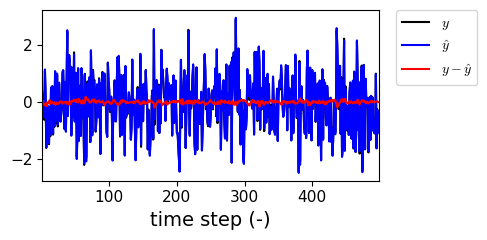

In [88]:
t = np.arange(1, batch_y.shape[1])
plt.figure(figsize=(5, 2.5))

idx = 45
plt.plot(t, batch_y_target[idx], 'k', label="$y$")
plt.plot(t, batch_y_pred[idx], 'b', label="$\hat y$")
#plt.plot(batch_y_pred_dummy[idx], 'm', label="Pred dummy")
plt.plot(t, batch_y_target[idx] - batch_y_pred[idx], 'r', label="$y - \hat y$")
#plt.plot(batch_y_target[idx] - batch_y_pred_dummy[idx], 'm', label="Err dummy")
#plt.legend(loc="upper right")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()
#plt.xlim([0, 50]);
#plt.ylim([-3, 3]);
plt.xlabel("time step (-)")
plt.tight_layout()

In [89]:
# reference
Ts = 0.1

step_reference = False

if step_reference:
    t_CL = np.arange(0, 50, Ts)
    r = np.zeros(t_CL.shape)
    r[t_CL < 50] = 10
    
else:
    tmp_ds = CampiExample1Dataset(seq_len=500, normalize=False, return_y=True)
    tmp_dl = DataLoader(tmp_ds, batch_size=1)
    batch_u, batch_e_v, batch_y = next(iter(tmp_dl))
    y = batch_y.numpy().flatten()
    t_CL = np.arange(0,len(y))*Ts
    # Desired variable to be controlled is x1 = \theta. Let's compute virtual error
    s = tf('s')
    M = (1e-1*s + 1) / (3*s + 1)
    r = lsim(M**(-1), y, t_CL)[0]

In [90]:
n_testing = 0
H = 500 

# e = torch.Tensor([[[]]])
# u = torch.Tensor([[[]]])


y_log = np.zeros((len(data_test),len(t_CL)))
e_log = np.zeros((len(data_test),len(t_CL)))
u_log = np.zeros((len(data_test),len(t_CL)))
u_prev_log = np.zeros((len(data_test),len(t_CL)))

Ts = 0.1; Fs = 1 / Ts
s = tf('s')
# problem data


with torch.no_grad():
    for n_testing in range(1):#len(data_test)):
        
        print(n_testing)
        
        e = torch.Tensor([[[]]])
        u = torch.Tensor([[[]]])
        
        x_i = np.array([1e-6, 1e-6, 1e-6, 1e-6])
        y_i = x_i[0]
        u_i = 1e-6
        
        data = data_test[n_testing]
        # system
        P = ((data['m1'] * s ** 2 + (data['c1'] + data['c2']) * s + (data['k1'] + data['k2'])) /
            ((data['m1'] * s ** 2 + (data['c1'] + data['c2']) * s + (data['k1'] + data['k2'])) *
             (data['m2'] * s ** 2 +  data['c2'] * s + data['k2']) - (data['k2'] + data['c2'] * s) ** 2))  
        
        for i in range(len(t_CL)-1):#batch_u.shape[0]): # for each system
    
            # normalize
            u_i /= 10
            e_i = (r[i] - y_i)/17
            
            u_i_prev = torch.Tensor([[[u_i]]]) 
            e_i = torch.Tensor([[[e_i]]])
            
            y_log[n_testing,i] = y_i
            e_log[n_testing,i] = e_i*17
            #u_prev_log[n_testing,i] = u_i_prev
    
            e = torch.cat((e,e_i),2)
            u = torch.cat((u,u_i_prev),2)

            #print(e.shape)
            # e = e_i
            # u = torch.Tensor([[[u_i]]])
    
            # Controller

            if i < H:
                pred, _ = model(e.reshape(1,-1,1), u.reshape(1,-1,1))
            else:
                e_tmp = e.reshape(1,-1,1)
                u_tmp = u.reshape(1,-1,1)
                pred, _ = model(e_tmp[:,-H:,:], u_tmp[:,-H:,:])
    
            u_i = pred[:,-1,:].item() * 10
            #u_i = batch_u.numpy().flatten()[i+1]
            u_log[n_testing,i] = u_i
    
            # simulation
            y_i_old = y_i
            y_i, _, x_i = lsim(P, u_i, np.array([0.0, Ts]), x_i[-1])
            y_i = y_i[-1]
        

/home/rbusetto/.conda/envs/transformers-control/lib/python3.10/site-packages/control/timeresp.py:946: UserWarning: Non-zero initial condition given for transfer function system. Internal conversion to state space used; may not be consistent with given X0.
  warnings.warn(


0


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

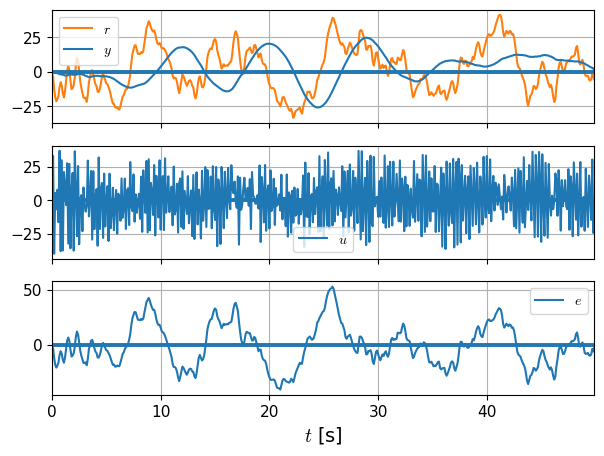

In [91]:
fig = plt.figure(figsize=(7, 5))
ax1 = plt.subplot(311)
#plt.plot(t_CL, r)
plt.plot(t_CL, r, label="$r$", c='tab:orange')
plt.plot(t_CL, y_log.T, label="$y$", c='tab:blue', alpha=1)
plt.legend(['$r$','$y$'])
plt.tick_params('x', labelbottom=False)

ax2 = plt.subplot(312, sharex=ax1)
plt.plot(t_CL, u_log.T, c='tab:blue', alpha=1)
plt.legend(['$u$'])
plt.tick_params('x', labelbottom=False)

ax3 = plt.subplot(313, sharex=ax1)
plt.plot(t_CL, e_log.T, c='tab:blue', alpha=1)
plt.xlabel('$t$ [s]')
plt.legend(['$e$'])

# plt.savefig('transformer_controller.pdf')

plt.show()

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

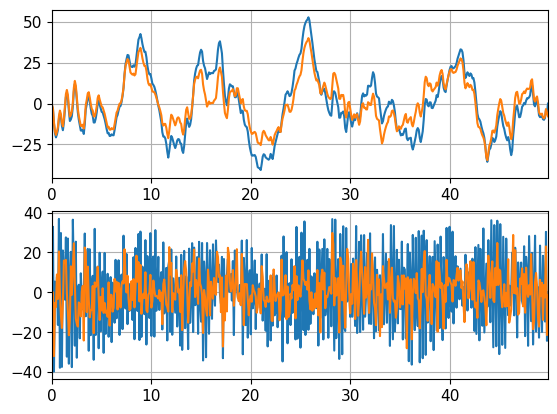

In [92]:
plt.subplot(211)
plt.plot(t_CL, e_log[0,:].T, c='tab:blue', alpha=1, label='$e_v$ computed in CL')
plt.plot(t_CL, batch_e_v.numpy().flatten(), c='tab:orange', label='$e_v$ generated')
plt.subplot(212)
plt.plot(t_CL, u_log[0,:].T, c='tab:blue', alpha=1, label='$u$ computed from model')
plt.plot(t_CL, batch_u.numpy().flatten(), c='tab:orange', label='$u$ generated')